In [119]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

from tqdm.notebook import tqdm

conf = SparkConf()

In [2]:
# Kubernetes is a Spark master in my setup. on my little cluster

conf.setAppName("Last Descriptive Analysis").setMaster("k8s://https://192.168.4.60:6443") 

# Worker pods are created from the base Spark docker image.
# If you use another image, specify its name instead.

conf.set(
    "spark.kubernetes.container.image", 
    "johnb340/spark-executor:v1alpha") 


conf.set(
    "spark.kubernetes.container.image.pullPolicy", 
    "IfNotPresent") 

# Authentication certificate and token (required to create worker pods):
conf.set(
    "spark.kubernetes.authenticate.caCertFile", 
    "/var/run/secrets/kubernetes.io/serviceaccount/ca.crt")
conf.set(
    "spark.kubernetes.authenticate.oauthTokenFile", 
    "/var/run/secrets/kubernetes.io/serviceaccount/token")

# Service account which should be used for the driver
conf.set(
    "spark.kubernetes.authenticate.driver.serviceAccountName", 
    "spark-minion") 

# 2 pods/workers will be created. Can be expanded for larger workloads.
conf.set("spark.executor.instances", "5") 

# The DNS alias for the Spark driver. Required by executors to report status.
conf.set( "spark.driver.host", "jupyter-spark-driver.default")

conf.set("spark.pyspark.driver.python","jupyter")

conf.set("spark.pyspark.driver.python.opts","notebook")

conf.set("spark.kubernetes.namespace","default")

conf.set("spark.driver.port", "20020")

# Initialize spark context, create executors
sc = pyspark.SparkContext(conf=conf)

23/02/24 03:10:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
#Let's load our data we saved from the munging step.
text_file = "finalRDD.csv"

In [4]:
df = pd.read_csv(text_file, error_bad_lines=False)

/tmp/ipykernel_8362/2856737018.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(text_file, error_bad_lines=False)


In [5]:
df.head()

,560200,825695534,27035,gustavo cerati,41
0,560300,825461477,27047,the view,87
1,560400,825558122,27059,taking back sunday,190
2,560500,826668727,27059,taking back sunday,720
3,560600,826689144,27059,taking back sunday,26
4,560700,830124153,27063,norah jones,86


In [6]:
spark = SparkSession(sc)

In [7]:
df = spark.createDataFrame(df)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [8]:
plays = df.rdd

In [9]:
plays.take(5)

23/02/24 03:10:33 WARN TaskSetManager: Stage 0 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


[Row(560200=560300,  825695534=825461477,  27035=27047,  gustavo cerati=' the view',  41=87),
 Row(560200=560400,  825695534=825558122,  27035=27059,  gustavo cerati=' taking back sunday',  41=190),
 Row(560200=560500,  825695534=826668727,  27035=27059,  gustavo cerati=' taking back sunday',  41=720),
 Row(560200=560600,  825695534=826689144,  27035=27059,  gustavo cerati=' taking back sunday',  41=26),
 Row(560200=560700,  825695534=830124153,  27035=27063,  gustavo cerati=' norah jones',  41=86)]

In [10]:
plays.count()

23/02/24 03:10:36 WARN TaskSetManager: Stage 1 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


699998

In [11]:
#find number of artists
artist_count = plays.map(lambda x: (x[3])).distinct().count()

23/02/24 03:10:43 WARN TaskSetManager: Stage 2 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [12]:
print("The number of artists is: {:d}".format(artist_count))

The number of artists is: 67553


In [13]:
# Find the number of users
user_count = plays.map(lambda x: (x[1])).distinct().count()

23/02/24 03:10:47 WARN TaskSetManager: Stage 4 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [14]:
print("The number of users is: {:d}".format(user_count))

The number of users is: 14325


In [15]:
# find the number of entries
number_of_entries = plays.count()

23/02/24 03:10:52 WARN TaskSetManager: Stage 6 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [16]:
print("The number of listener counts is: {:d}".format(number_of_entries))

The number of listener counts is: 699998


In [17]:
# find the average number of plays
sum_of_ratings = plays.map(lambda x: (int(x[4]))).reduce(lambda x,y: x + y)

23/02/24 03:10:55 WARN TaskSetManager: Stage 7 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [18]:
average_number_of_listens = sum_of_ratings/float(number_of_entries)

In [19]:
print('The average rating is: {:.2f}'.format(average_number_of_listens))

The average rating is: 215.77


In [20]:
print('The largest number of listens is: {:d}'.format(plays.map(lambda x:(int(x[4]))).max()))

23/02/24 03:11:16 WARN TaskSetManager: Stage 8 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


The largest number of listens is: 135392


In [21]:
print('The smallest number of listens is: {:d}'.format(plays.map(lambda x:(int(x[4]))).min()))

23/02/24 03:11:21 WARN TaskSetManager: Stage 9 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


The smallest number of listens is: 1


In [22]:
# Let's look at the number of times an artist is rated
rated_number = plays.map(lambda x: (x[2])).countByValue()

23/02/24 03:11:37 WARN TaskSetManager: Stage 10 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [23]:
# Let's look at the number of times an artist is rated
rated_ = []
for item in rated_number.items():
    rated_.append((item[0],item[1]))

In [24]:
rated = sc.parallelize(rated_)

In [25]:
print('The highest-rated artist had : {:d} listens'.format(rated.map(lambda x: (int(x[1]))).max()))

The highest-rated artist had : 3072 listens


In [26]:
print('The average-rated artist had : {:f} listens'.format(rated.map(lambda x: (int(x[1]))).mean()))

The average-rated artist had : 10.362204 listens


In [27]:
print('The lowest-rated artist had : {:d} listens'.format(rated.map(lambda x: (int(x[1]))).min()))

The lowest-rated artist had : 1 listens


In [28]:
#We can see that that we have some values which are going to affect our model.
#It is doubley-clear in the visuals below

In [31]:
rated_num = plays.map(lambda x: (float(x[2]))).collect()

23/02/24 03:12:25 WARN TaskSetManager: Stage 14 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


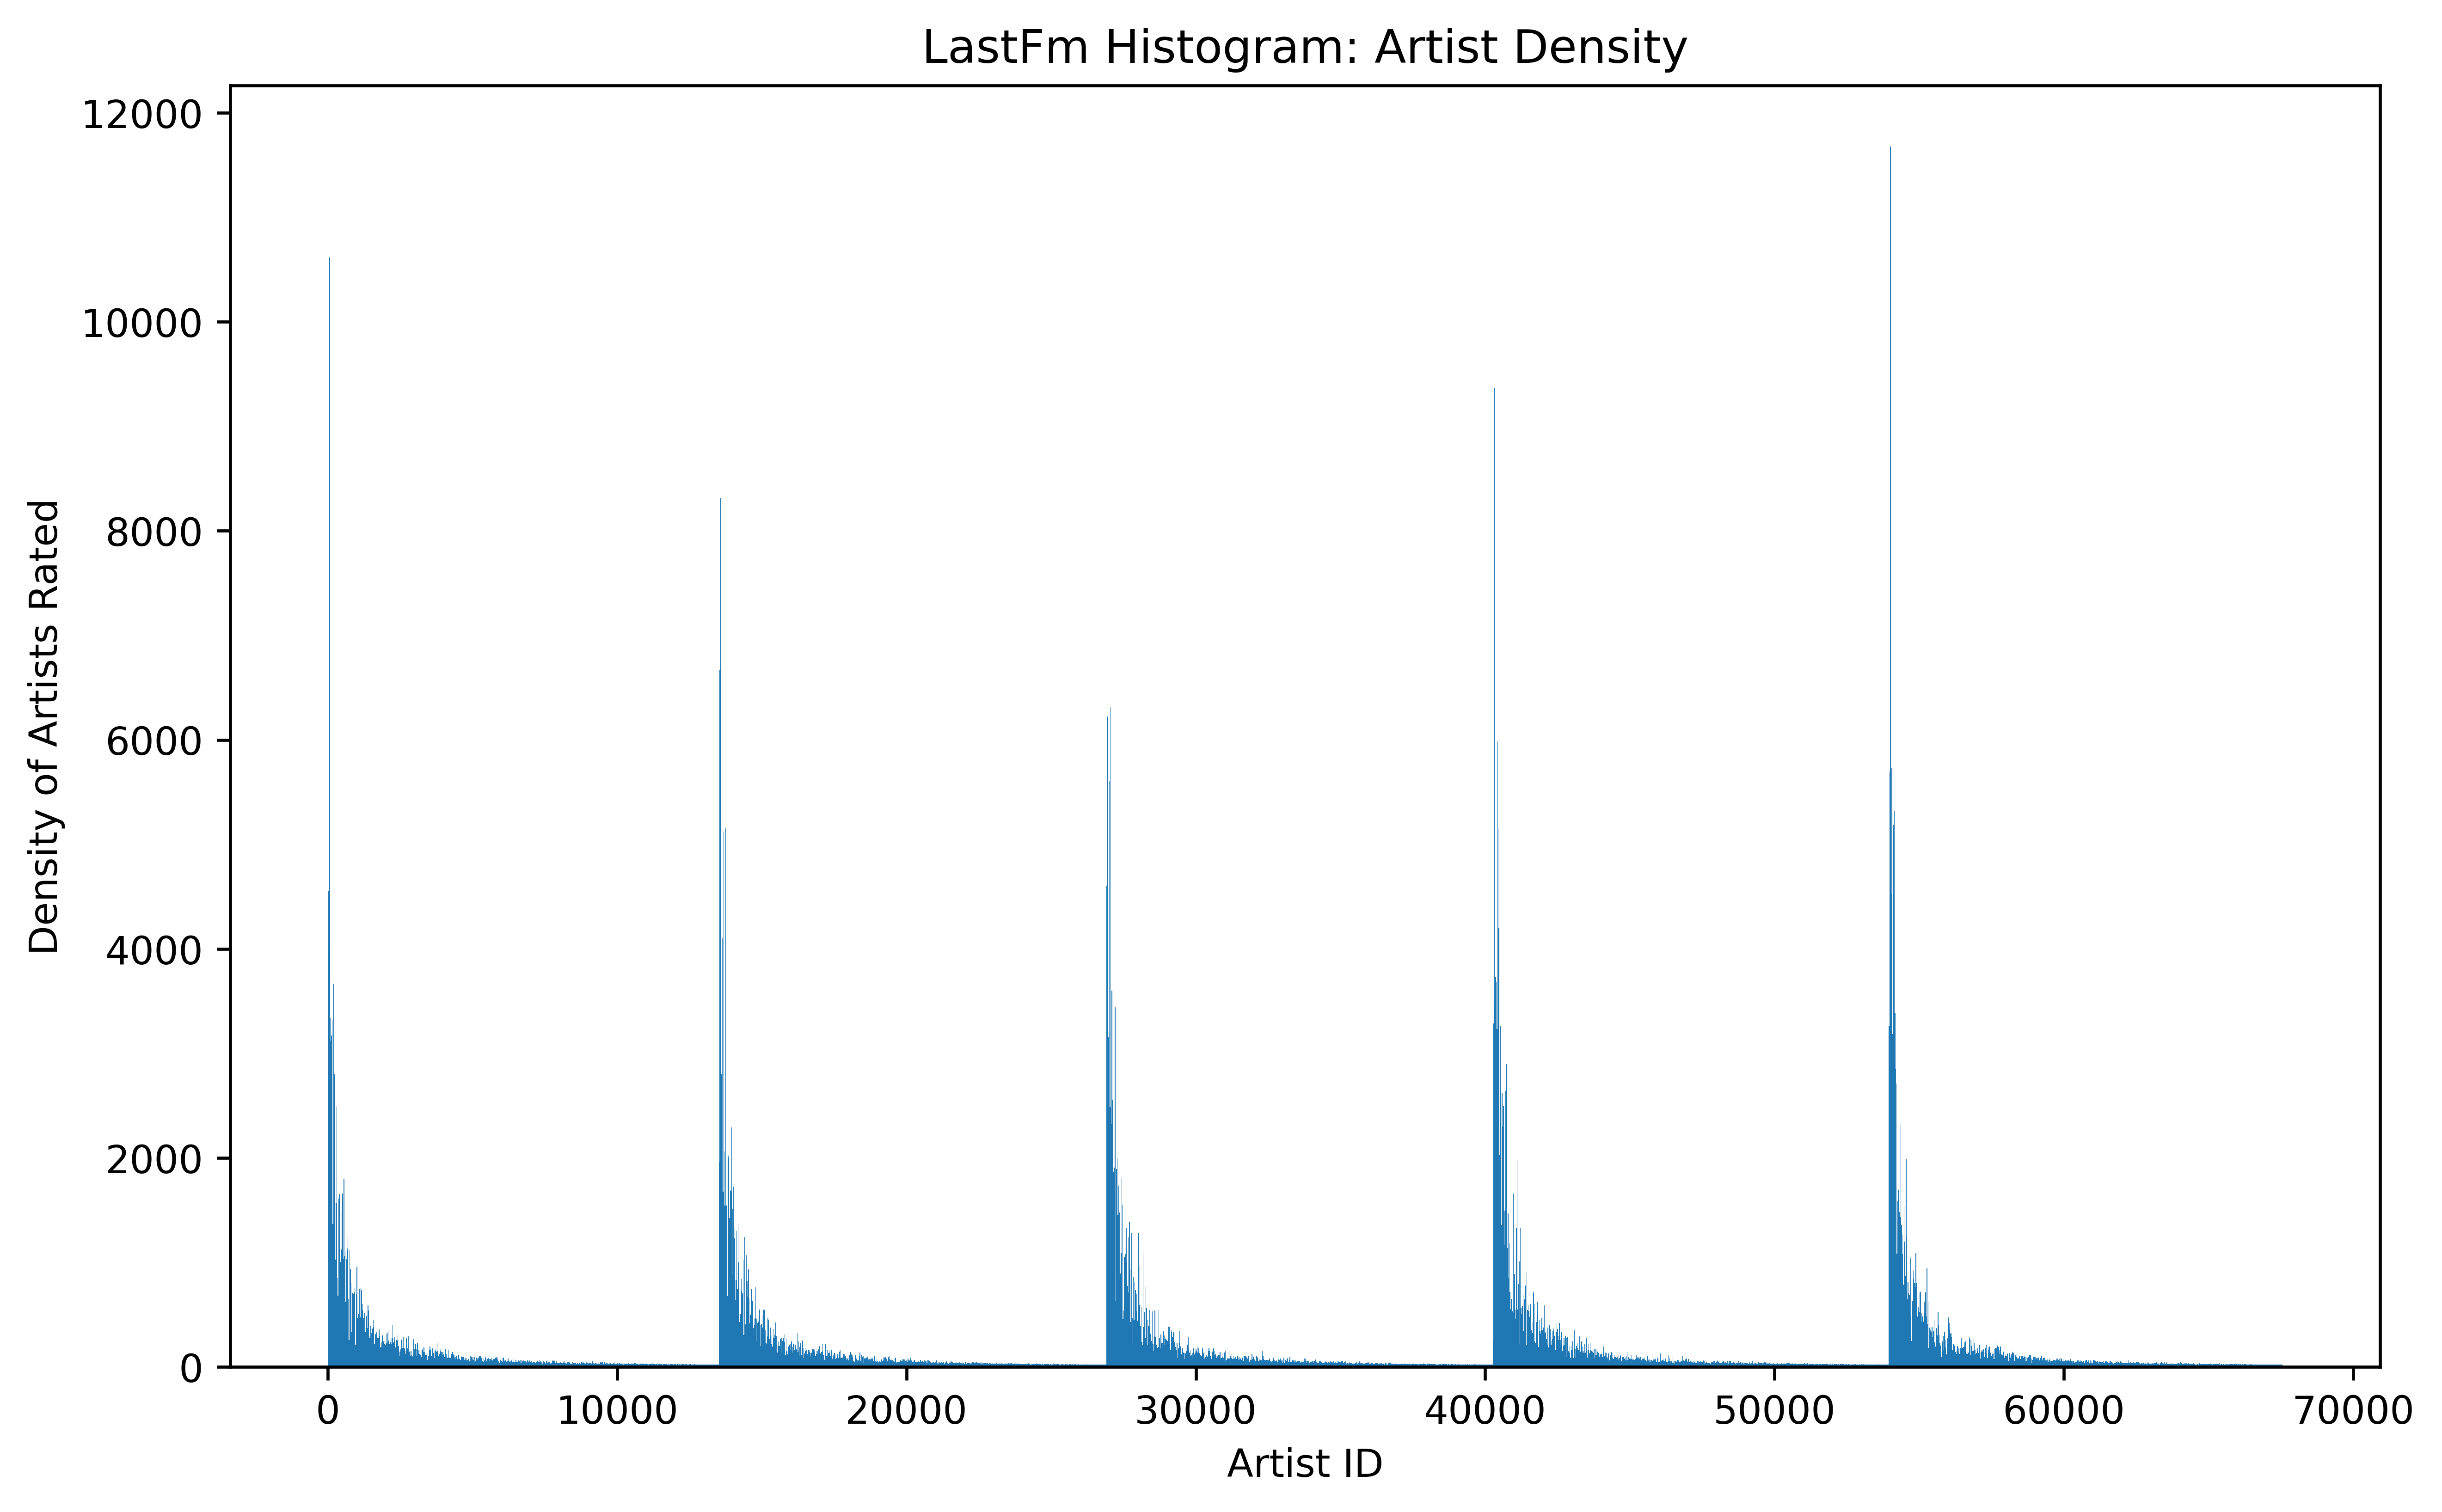

In [41]:
%matplotlib inline
plt.figure(num=None, figsize=(10, 6), dpi=600)
plt.hist(x=rated_num,bins=3000, density=False)

plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density')
plt.savefig("visuals/lastFMArtBefore.svg")

In [38]:
listens = plays.map(lambda x: (float(x[4]))).collect()

23/02/24 03:15:54 WARN TaskSetManager: Stage 15 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


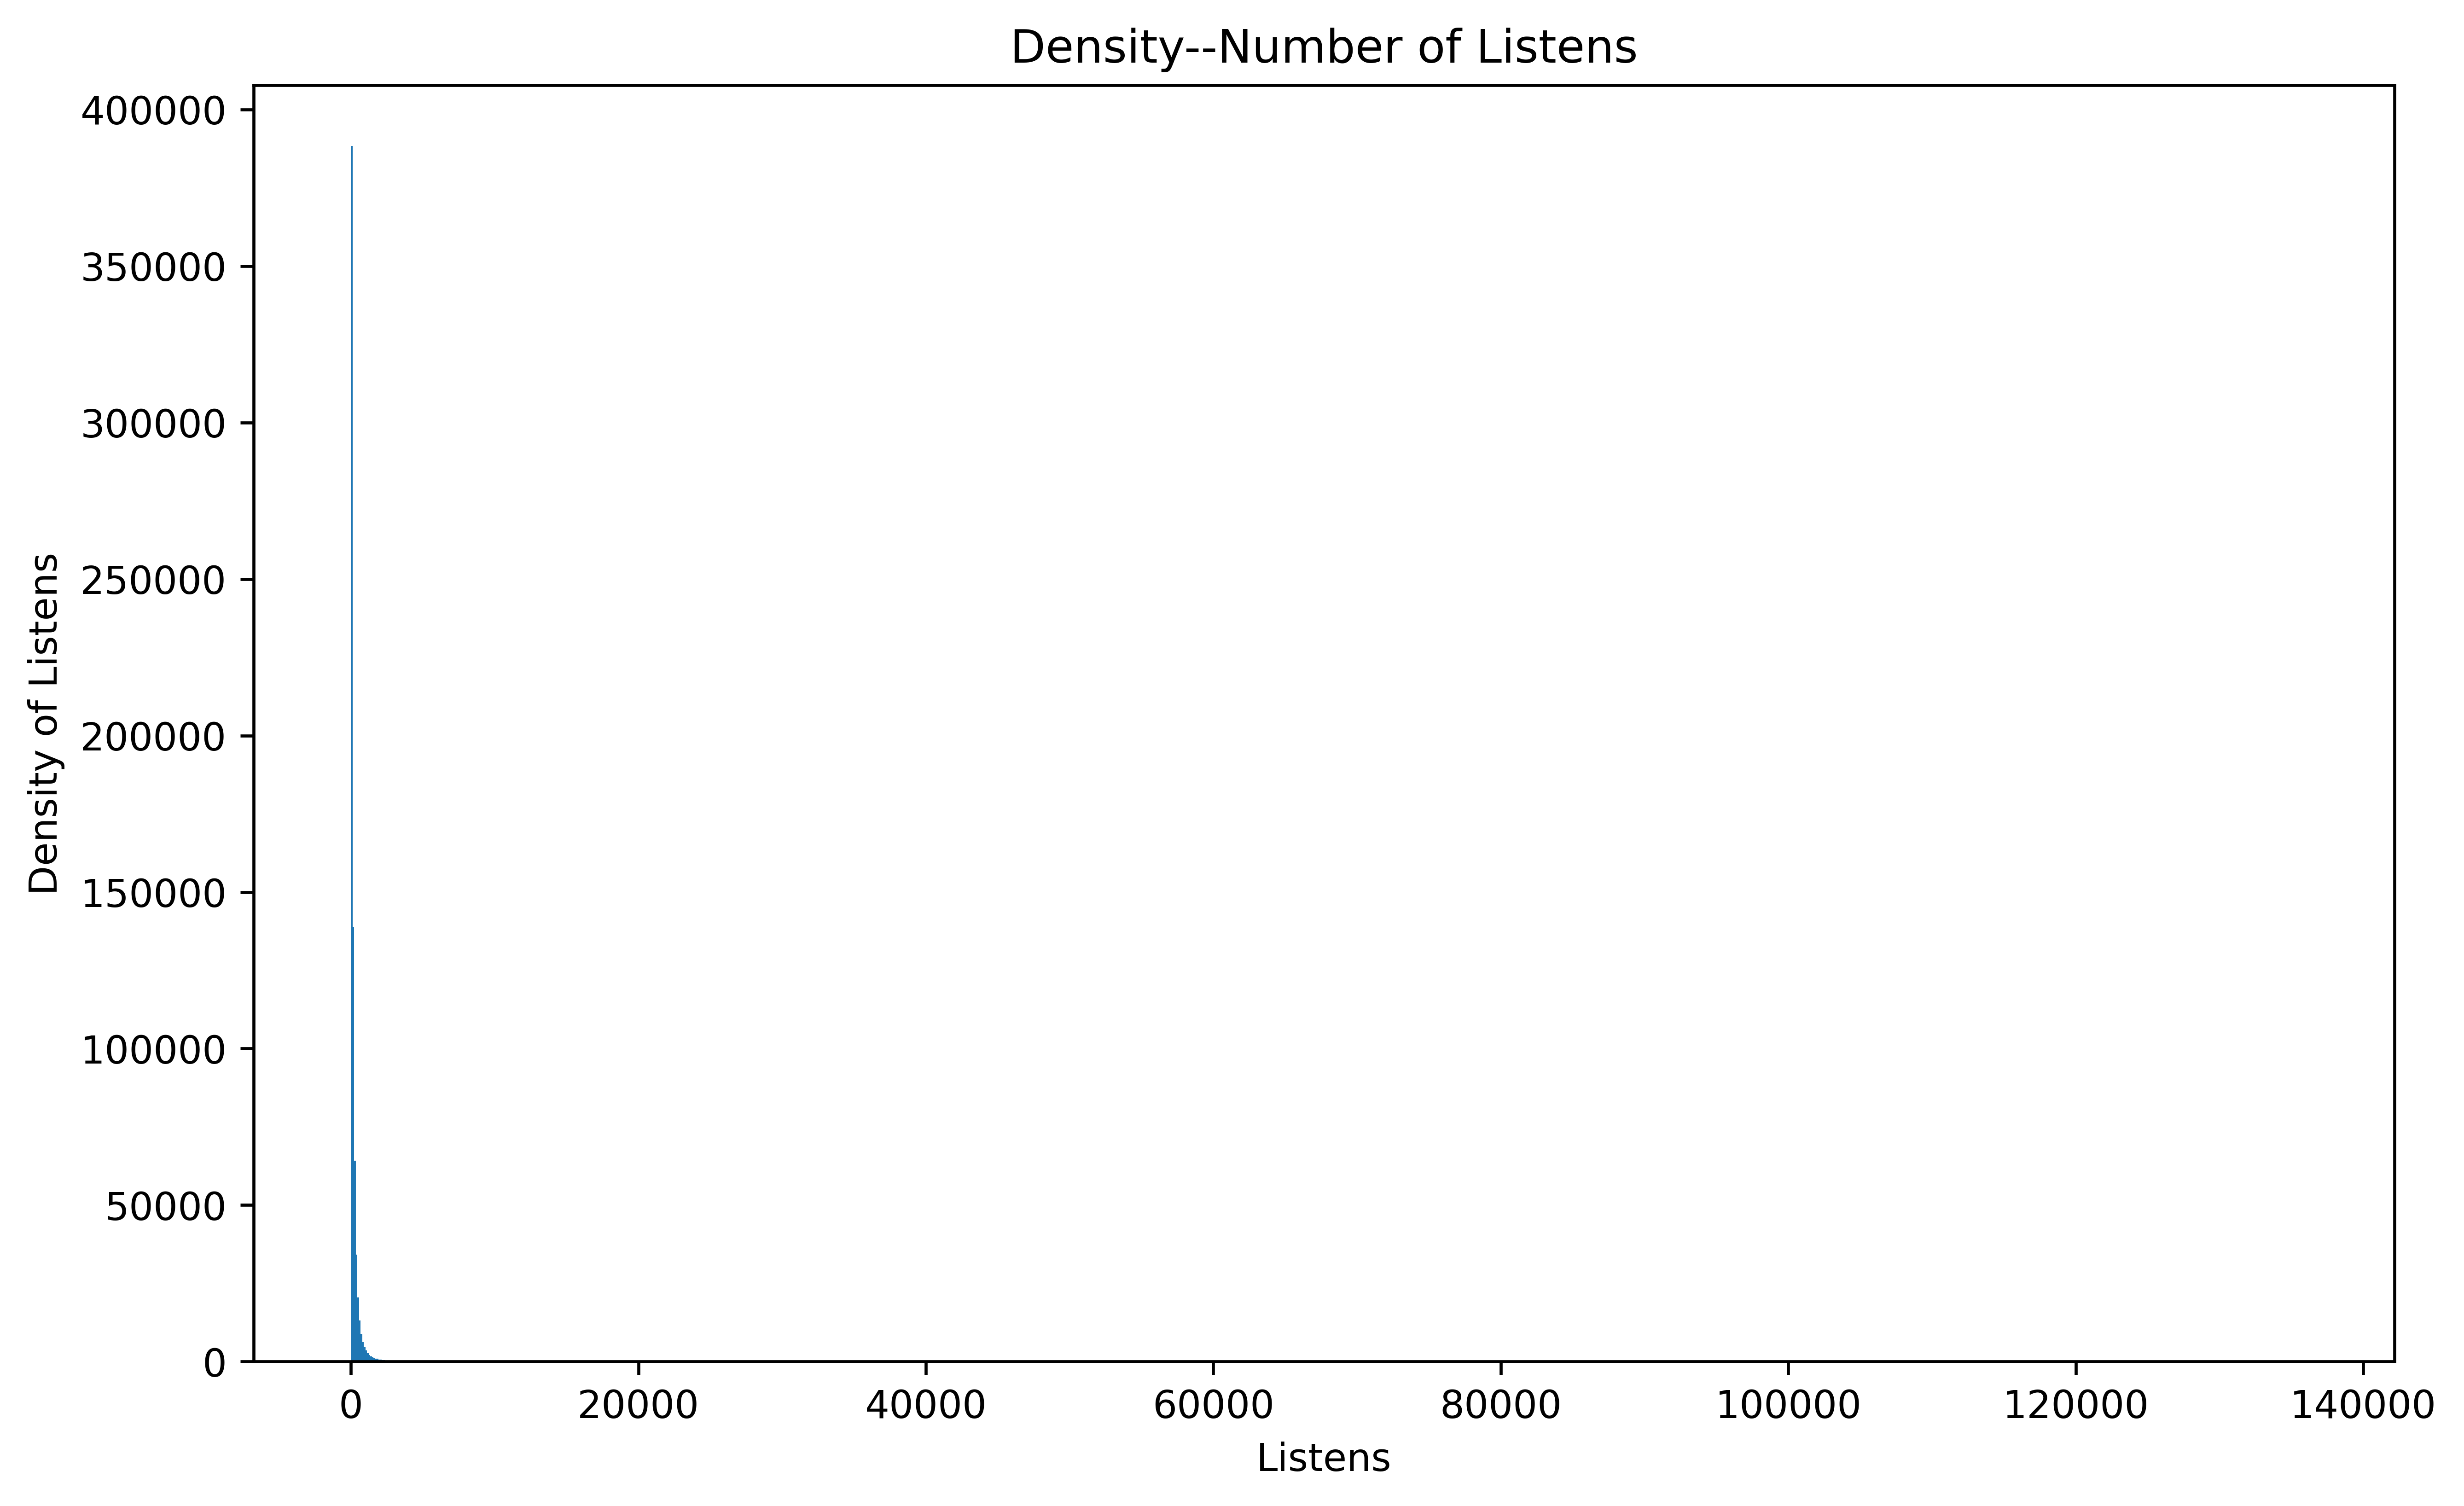

In [39]:
%matplotlib inline
plt.figure(num=40, figsize=(10, 6), dpi=600)
plt.xlabel('Listens')
plt.ylabel('Density of Listens')
plt.title("Density--Number of Listens")
plt.hist(x=listens,bins=1200,density=False)
plt.savefig("visuals/listenDensBefore.svg")

In [109]:
#Wow. We know there's something in the 400k range. We obviously have some outliers.
# In fact, we can probably go down to 1k to catch the tail.
#However, the highest numbers should lie around the mean. We see part of what might be a curve here.
# As we trim our data closer to our mean, we should see such a curve. But how much data will we lose?

In [42]:
plays.map(lambda x: (float(x[4]))).stats()

23/02/24 03:17:45 WARN TaskSetManager: Stage 16 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


(count: 699998, mean: 215.7749164997625, stdev: 613.5352880145781, max: 135392.0, min: 1.0)

In [46]:
#We can see the tail is now around 2k. But really, 2k? Thats the same song 2000/365 or about 5 1/2 times a day.  
# For my puposes I am going to choose a cutoff of 700. I love music and am passionate about many artists, but
# I really dont think I even approach 700.
rdd700 = plays.filter(lambda x: x[4] < 700)

In [47]:
listens4 = rdd700.map(lambda x: (float(x[4]))).collect()

23/02/24 03:22:41 WARN TaskSetManager: Stage 18 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


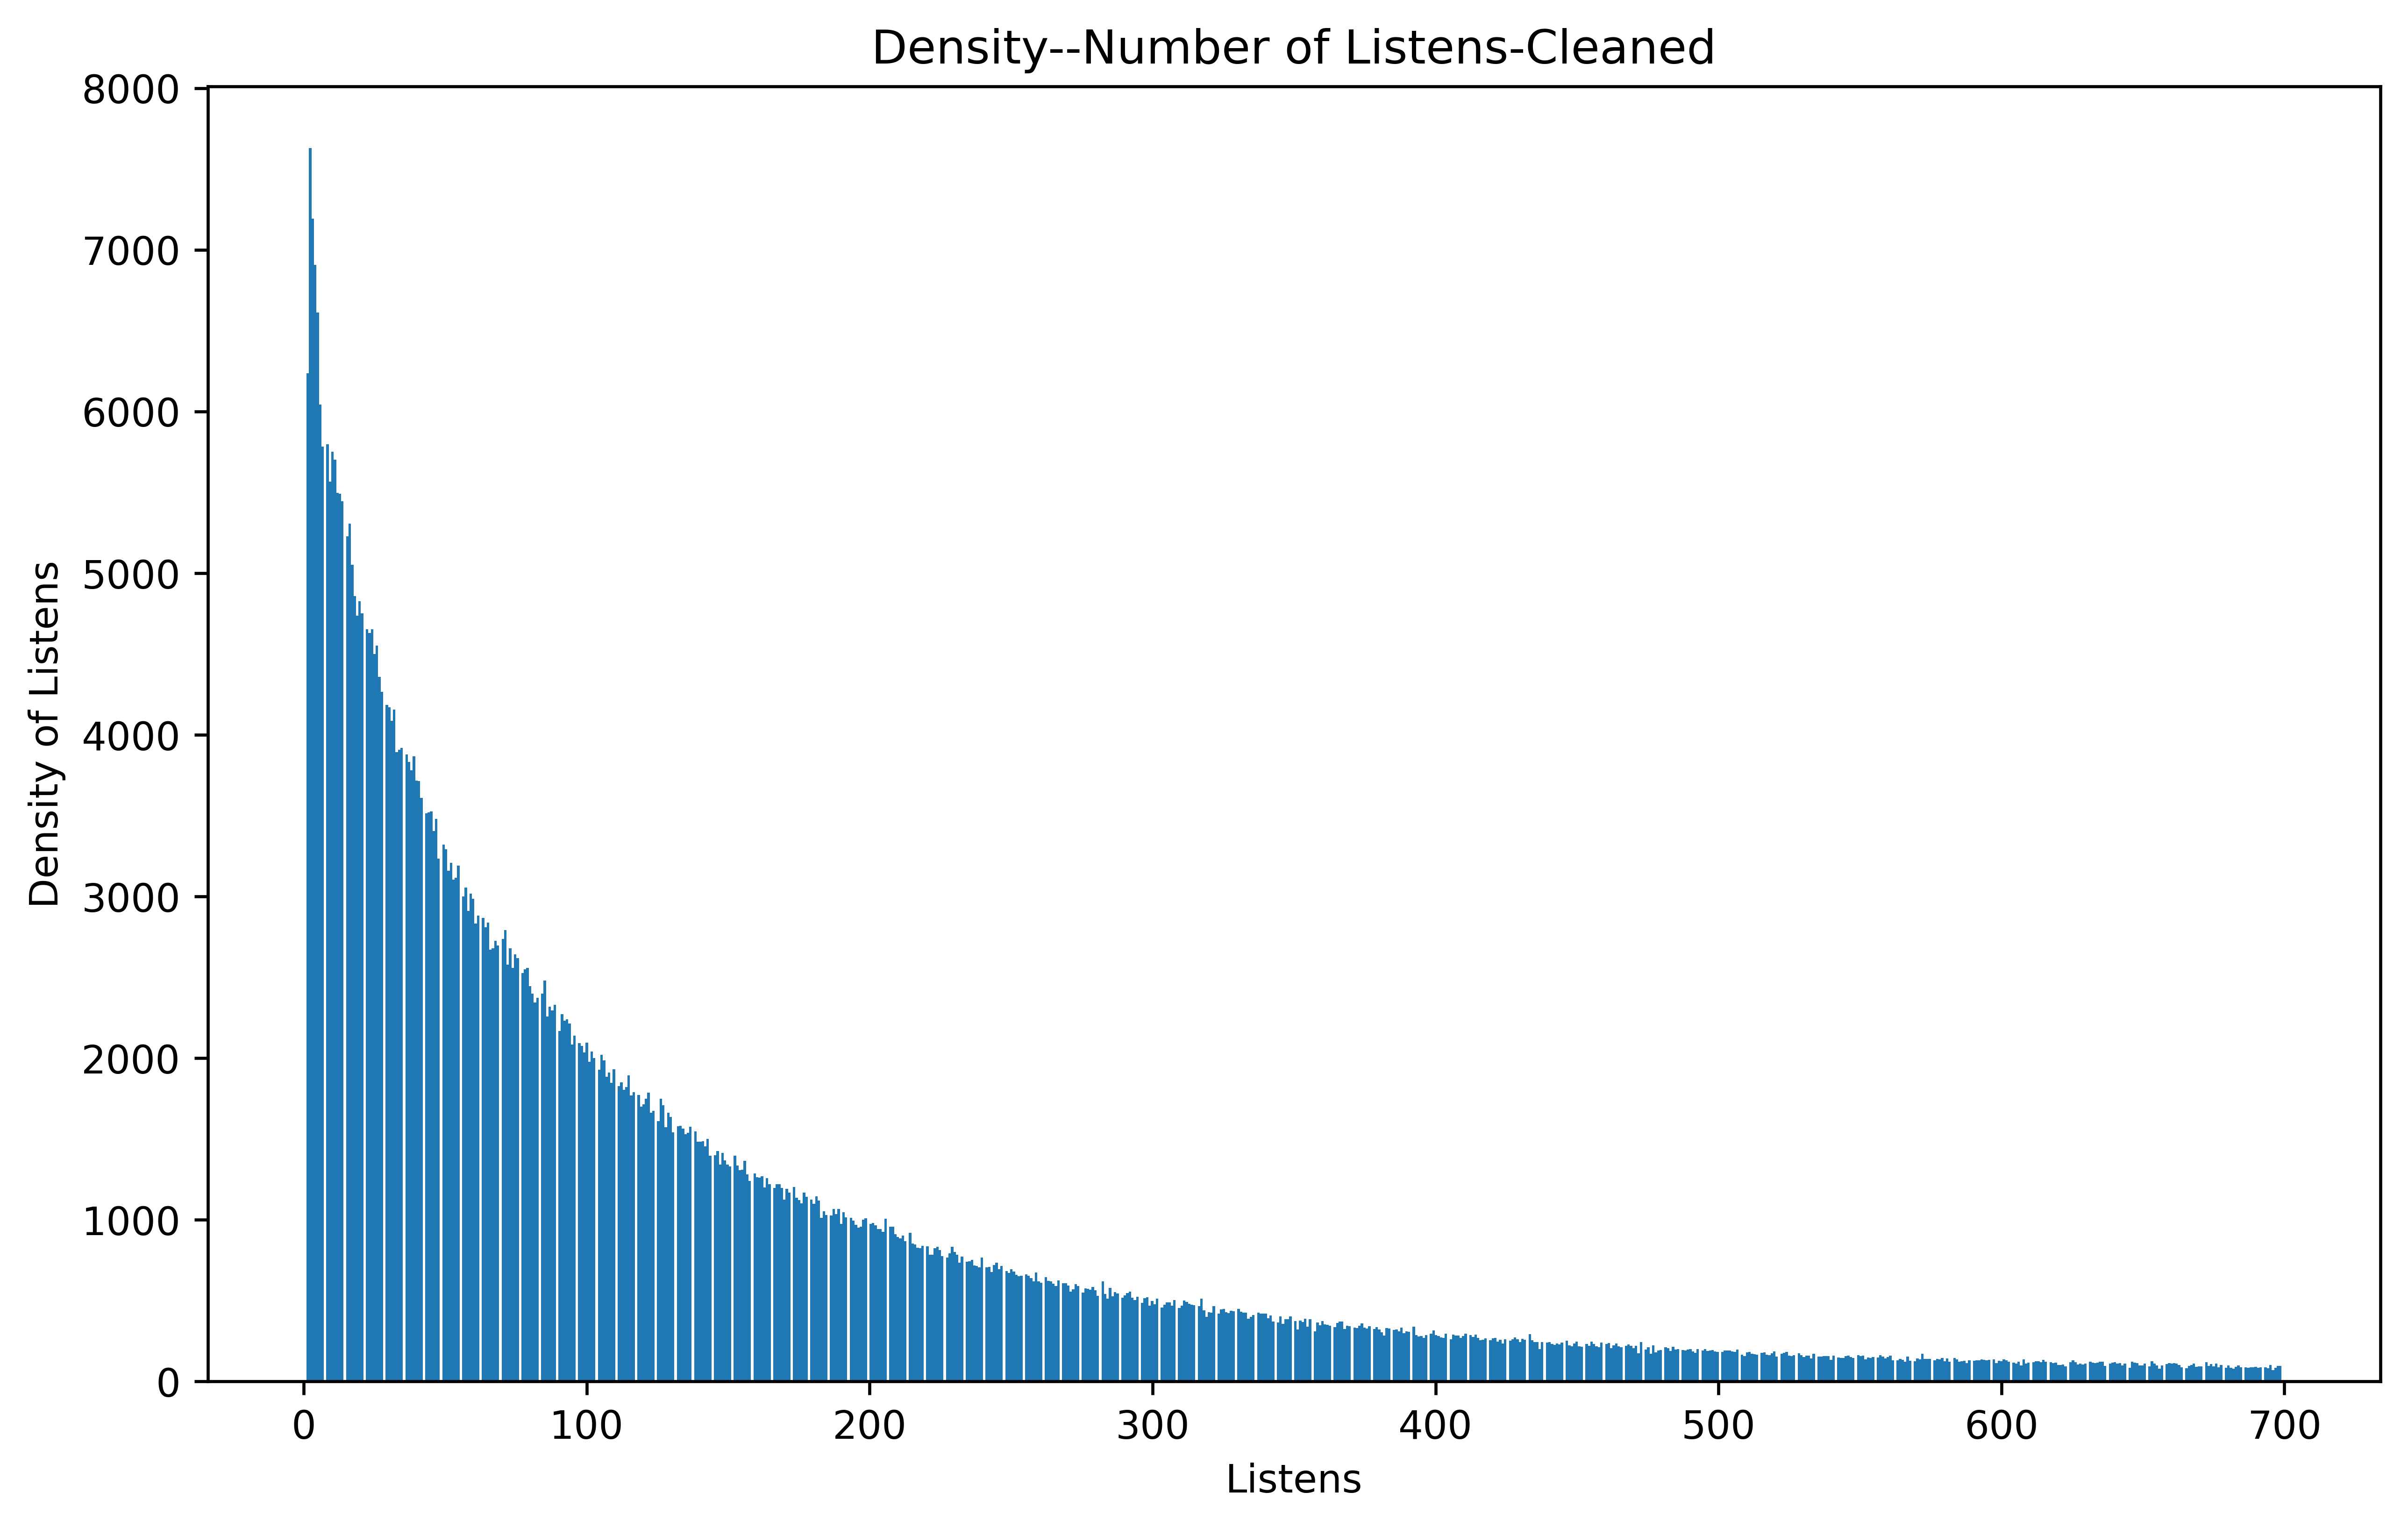

In [48]:
%matplotlib inline
plt.figure(num=400, figsize=(10, 6), dpi=600)
plt.hist(x=listens4,bins=800)
plt.xlabel('Listens')
plt.ylabel('Density of Listens')
plt.title("Density--Number of Listens-Cleaned")
plt.savefig("visuals/listenDensAfter.svg")

In [51]:
a700 = rdd700.map(lambda x: (x[2])).distinct().count()

23/02/24 03:24:49 WARN TaskSetManager: Stage 23 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [52]:
p700 = plays.map(lambda x: (x[2])).distinct().count()

23/02/24 03:25:20 WARN TaskSetManager: Stage 25 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [54]:
diff = p700-a700

In [55]:
print('We lost a bit, but still this is only {:.3f}% of the data'.format(diff/p700)) 

We lost a bit, but still this is only 0.040% of the data


In [56]:
rdd700.map(lambda x: (float(x[4]))).stats()

23/02/24 03:26:13 WARN TaskSetManager: Stage 27 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


(count: 661054, mean: 137.39146121194372, stdev: 145.0474042464167, max: 699.0, min: 1.0)

In [57]:
rdd700.map(lambda x: (x[3])).distinct().count()

23/02/24 03:26:18 WARN TaskSetManager: Stage 28 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


64843

In [58]:
#We got the counts under control now, let's look at our artist listens again:

In [79]:
rated_num2 = rdd700.map(lambda x: (float(x[2]))).collect()

23/02/24 03:31:32 WARN TaskSetManager: Stage 42 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


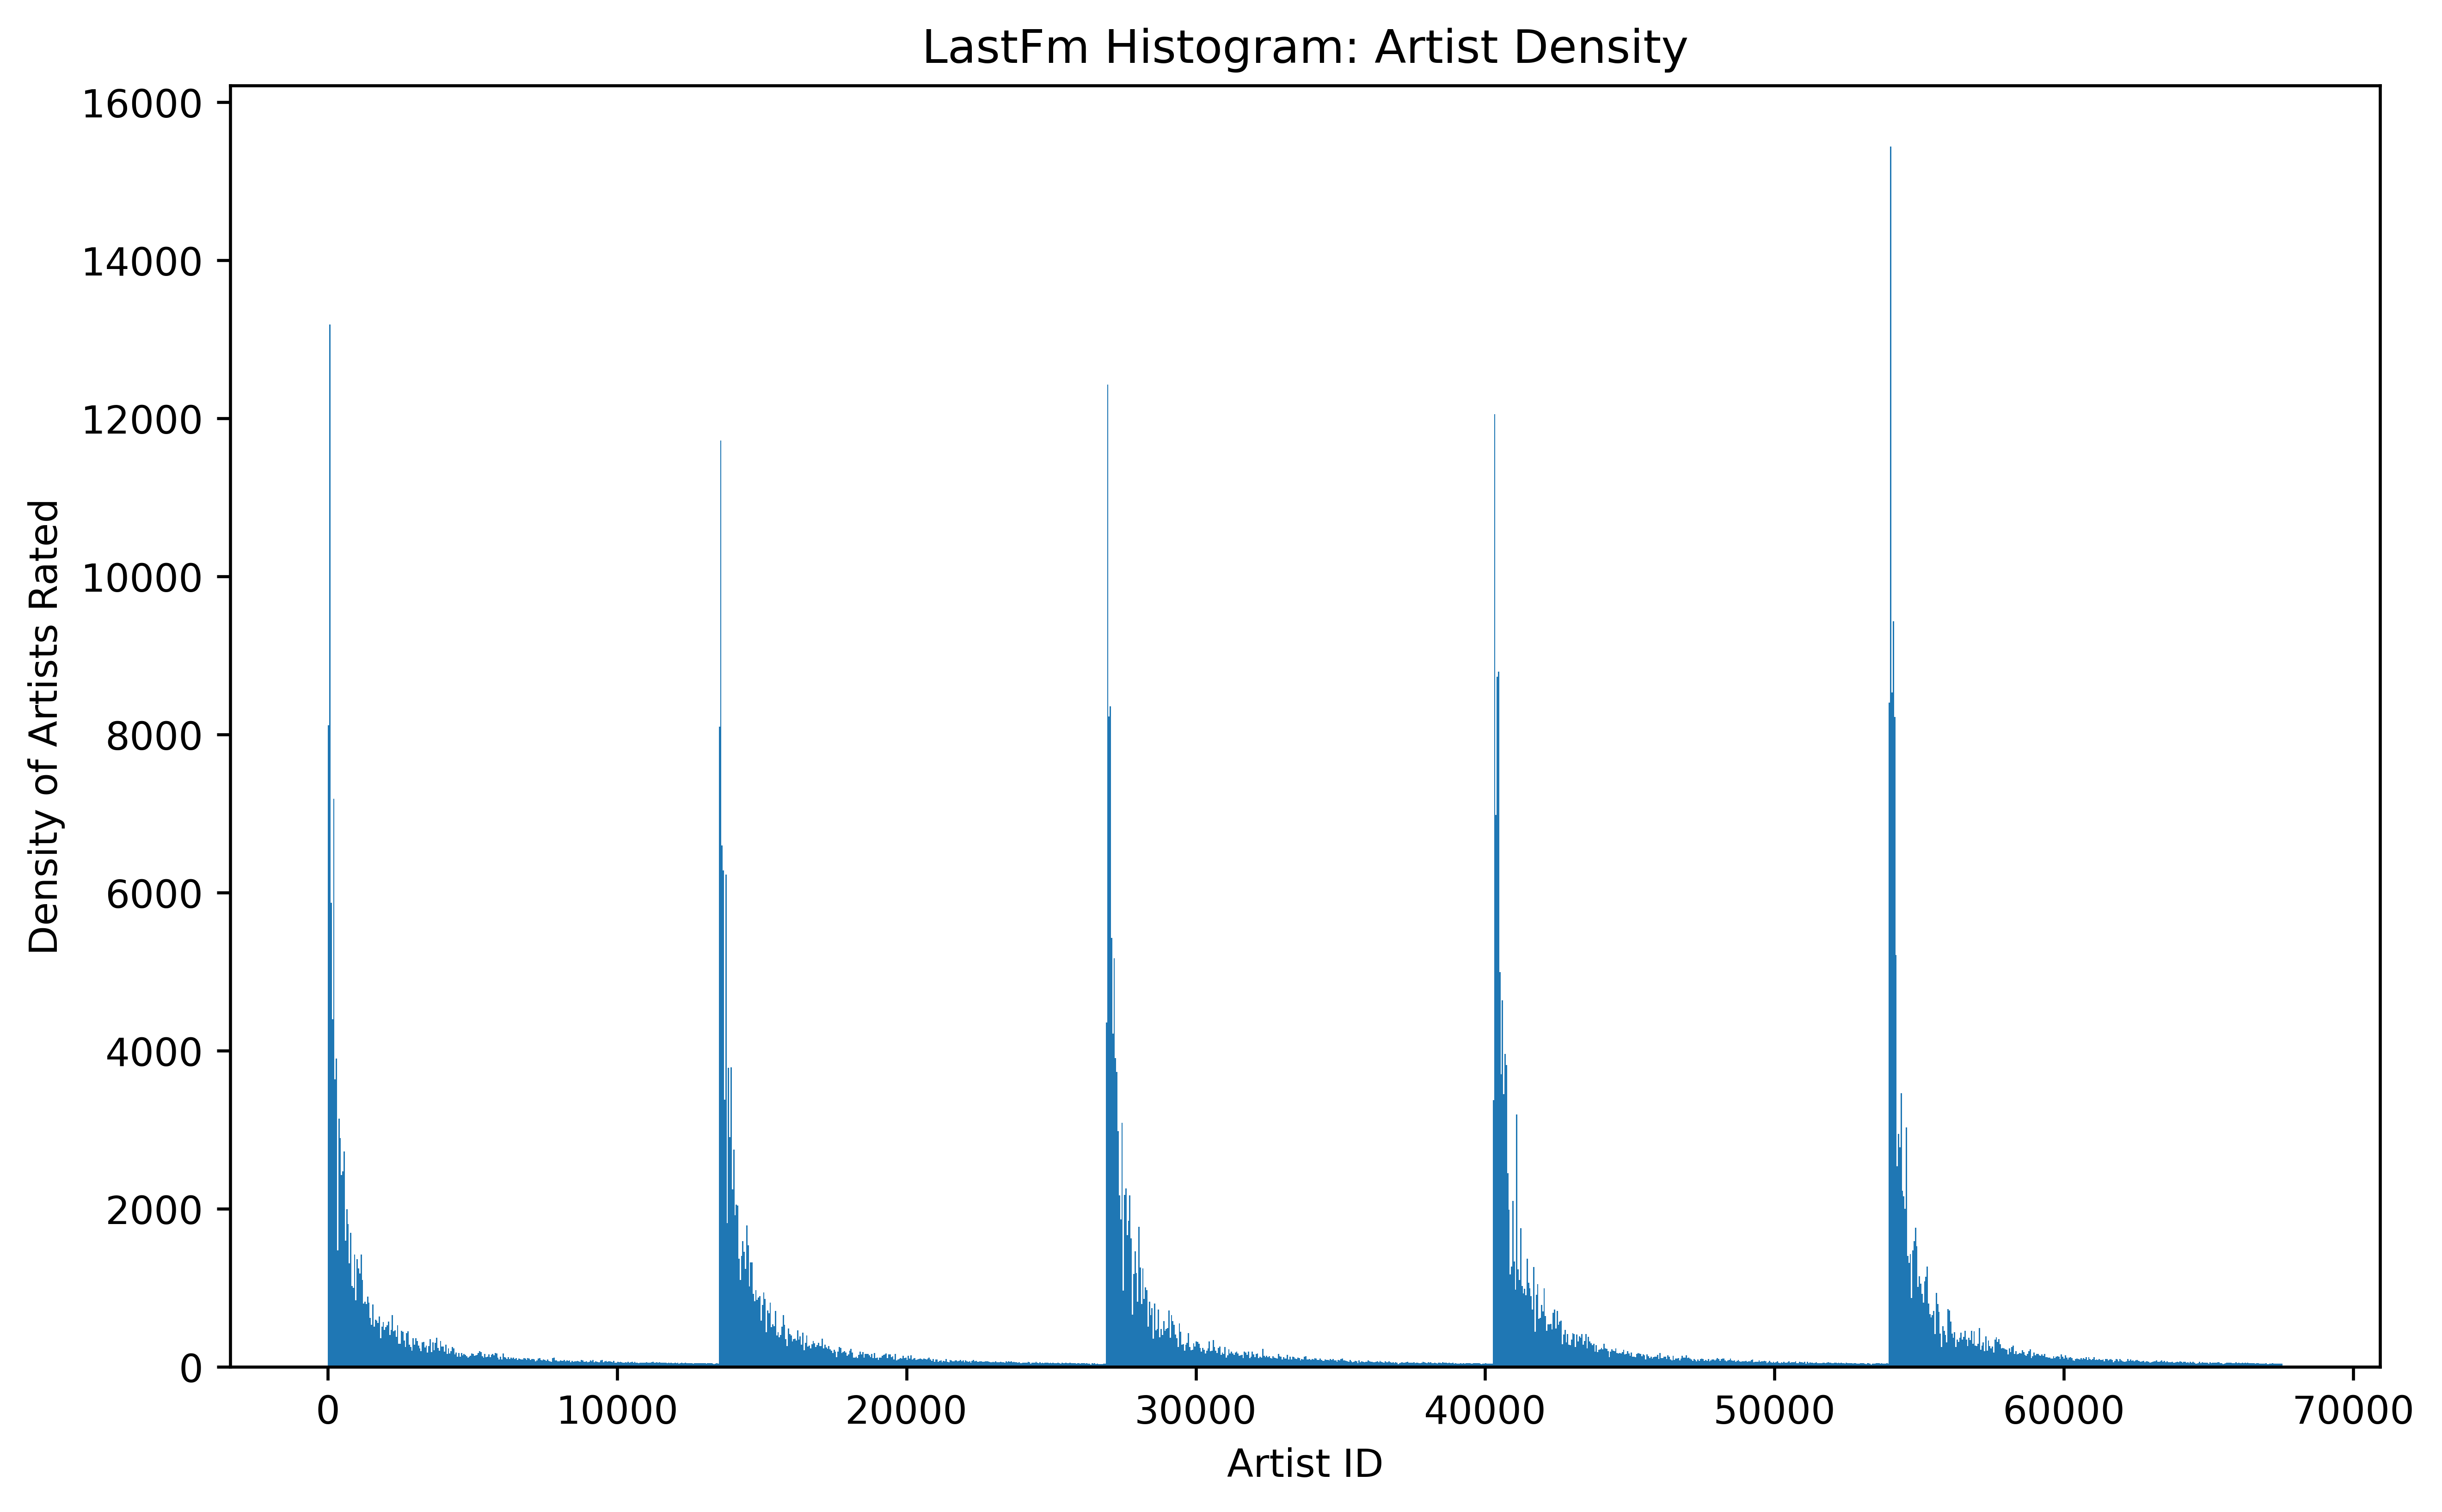

In [60]:
%matplotlib inline
x = rated_num2

plt.figure(num=None, figsize=(10, 6), dpi=600)
plt.hist(x,bins=1500,density=False)
plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density')

plt.savefig('visuals/ArtDenseBefor.svg')

plt.show()

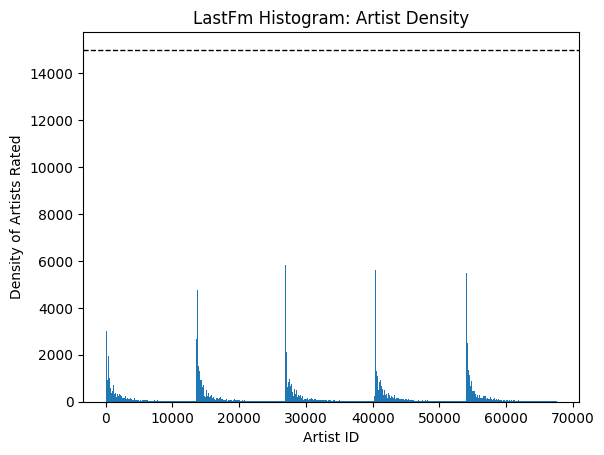

In [61]:
#It looks like 11k might be a good cutoff. Let's see how that looks
%matplotlib inline
x = rated_num2
plt.hist(x,bins=3000)
plt.axhline(15000, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density')
plt.savefig('visuals/ArtDenseafter.svg')
plt.show()

In [18]:
# To see if we should eliminate the large values or just reduce them, let's see if these are outliers or
# potentially important

In [62]:
#rated_number2 = rdd700.map(lambda x: (x[2])).countByValue()

23/02/24 03:27:15 WARN TaskSetManager: Stage 31 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [80]:
# Let's look at the number of times an artist is rated

rated_2 = []
for item in rated_number2.items():
    rated_2.append((item[0],item[1]))

In [81]:
len(rated_2)

64843

In [82]:
ratedRDD = sc.parallelize(rated_2)

In [83]:
ratedRDD.map(lambda x: (x[1])).stats()

(count: 64843, mean: 10.194685625279511, stdev: 53.270759880272536, max: 2936.0, min: 1.0)

In [84]:
#Let's take 3x the mean and see what happens to the dataset
overRatedArtists = ratedRDD.filter(lambda a: (a[1] > 180))

In [85]:
overRatedArtists.map(lambda x: (x[0])).distinct().count()

584

In [86]:
overArtists = overRatedArtists.map(lambda x: (x[0])).collect()

In [87]:
artOverRDD = rdd700.filter(lambda x: (x[2] in overArtists))

In [88]:
artOverRDD.take(5)

23/02/24 03:31:59 WARN TaskSetManager: Stage 47 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


[Row(560200=560400,  825695534=825558122,  27035=27059,  gustavo cerati=' taking back sunday',  41=190),
 Row(560200=560600,  825695534=826689144,  27035=27059,  gustavo cerati=' taking back sunday',  41=26),
 Row(560200=560700,  825695534=830124153,  27035=27063,  gustavo cerati=' norah jones',  41=86),
 Row(560200=560800,  825695534=830635029,  27035=27063,  gustavo cerati=' norah jones',  41=146),
 Row(560200=560900,  825695534=830588212,  27035=27063,  gustavo cerati=' norah jones',  41=127)]

In [89]:
artOverRDD.count()

23/02/24 03:32:00 WARN TaskSetManager: Stage 48 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


252164

In [99]:
fract_dict = dict()
for artist in overArtists:
    fract_dict[artist] = .14

In [100]:
artOverRDDIndex = artOverRDD.keyBy(lambda x: (x[2]))

In [101]:
artOverRDDIndex.take(5)

23/02/24 03:37:07 WARN TaskSetManager: Stage 54 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


[(27059,
  Row(560200=560400,  825695534=825558122,  27035=27059,  gustavo cerati=' taking back sunday',  41=190)),
 (27059,
  Row(560200=560600,  825695534=826689144,  27035=27059,  gustavo cerati=' taking back sunday',  41=26)),
 (27063,
  Row(560200=560700,  825695534=830124153,  27035=27063,  gustavo cerati=' norah jones',  41=86)),
 (27063,
  Row(560200=560800,  825695534=830635029,  27035=27063,  gustavo cerati=' norah jones',  41=146)),
 (27063,
  Row(560200=560900,  825695534=830588212,  27035=27063,  gustavo cerati=' norah jones',  41=127))]

In [102]:
sampleArtOver = artOverRDDIndex.sampleByKey(False, fract_dict, 2)

In [103]:
sampleArtOver.take(5)

23/02/24 03:37:11 WARN TaskSetManager: Stage 55 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


[(27592,
  Row(560200=574400,  825695534=864863743,  27035=27592,  gustavo cerati=' my bloody valentine',  41=7)),
 (27655,
  Row(560200=575500,  825695534=868420284,  27035=27655,  gustavo cerati=' scorpions',  41=21)),
 (27773,
  Row(560200=577300,  825695534=870294532,  27035=27773,  gustavo cerati=' the national',  41=562)),
 (28038,
  Row(560200=580000,  825695534=879735531,  27035=28038,  gustavo cerati=' the dandy warhols',  41=512)),
 (40434,
  Row(560200=597600,  825695534=822904655,  27035=40434,  gustavo cerati=' linkin park',  41=45))]

In [104]:
#We have all the artists
sampleArtOver.map(lambda x: (x[1][2])).distinct().count()

23/02/24 03:37:25 WARN TaskSetManager: Stage 56 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


584

In [105]:
sampleArt = sampleArtOver.map(lambda x: (x[1][0],x[1][1],x[1][2],x[1][3],x[1][4]))

In [106]:
sampleArt.take(5)

23/02/24 03:37:31 WARN TaskSetManager: Stage 58 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


[(574400, 864863743, 27592, ' my bloody valentine', 7),
 (575500, 868420284, 27655, ' scorpions', 21),
 (577300, 870294532, 27773, ' the national', 562),
 (580000, 879735531, 28038, ' the dandy warhols', 512),
 (597600, 822904655, 40434, ' linkin park', 45)]

In [107]:
preBalanced = rdd700.map(tuple).subtract(artOverRDD.map(tuple))

In [108]:
balancedRDD = preBalanced.union(sampleArt)

In [109]:
balancedRDD.take(5)

23/02/24 03:37:35 WARN TaskSetManager: Stage 59 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


[(671909, 942369453, 56185, ' failure', 196),
 (674509, 943035703, 55412, ' vanilla sky', 8),
 (675809, 950811040, 55697, ' maylene and the sons of disaster', 205),
 (677709, 958783564, 54075, ' groove coverage', 21),
 (679409, 956192657, 53989, ' at the gates', 454)]

In [110]:
balancedRDD.count()

23/02/24 03:37:43 WARN TaskSetManager: Stage 62 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


444042

In [111]:
#We lost a lot of the dataset, but was it worth it?
rated_num3 = balancedRDD.map(lambda x: (float(x[2]))).collect()

23/02/24 03:37:51 WARN TaskSetManager: Stage 64 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


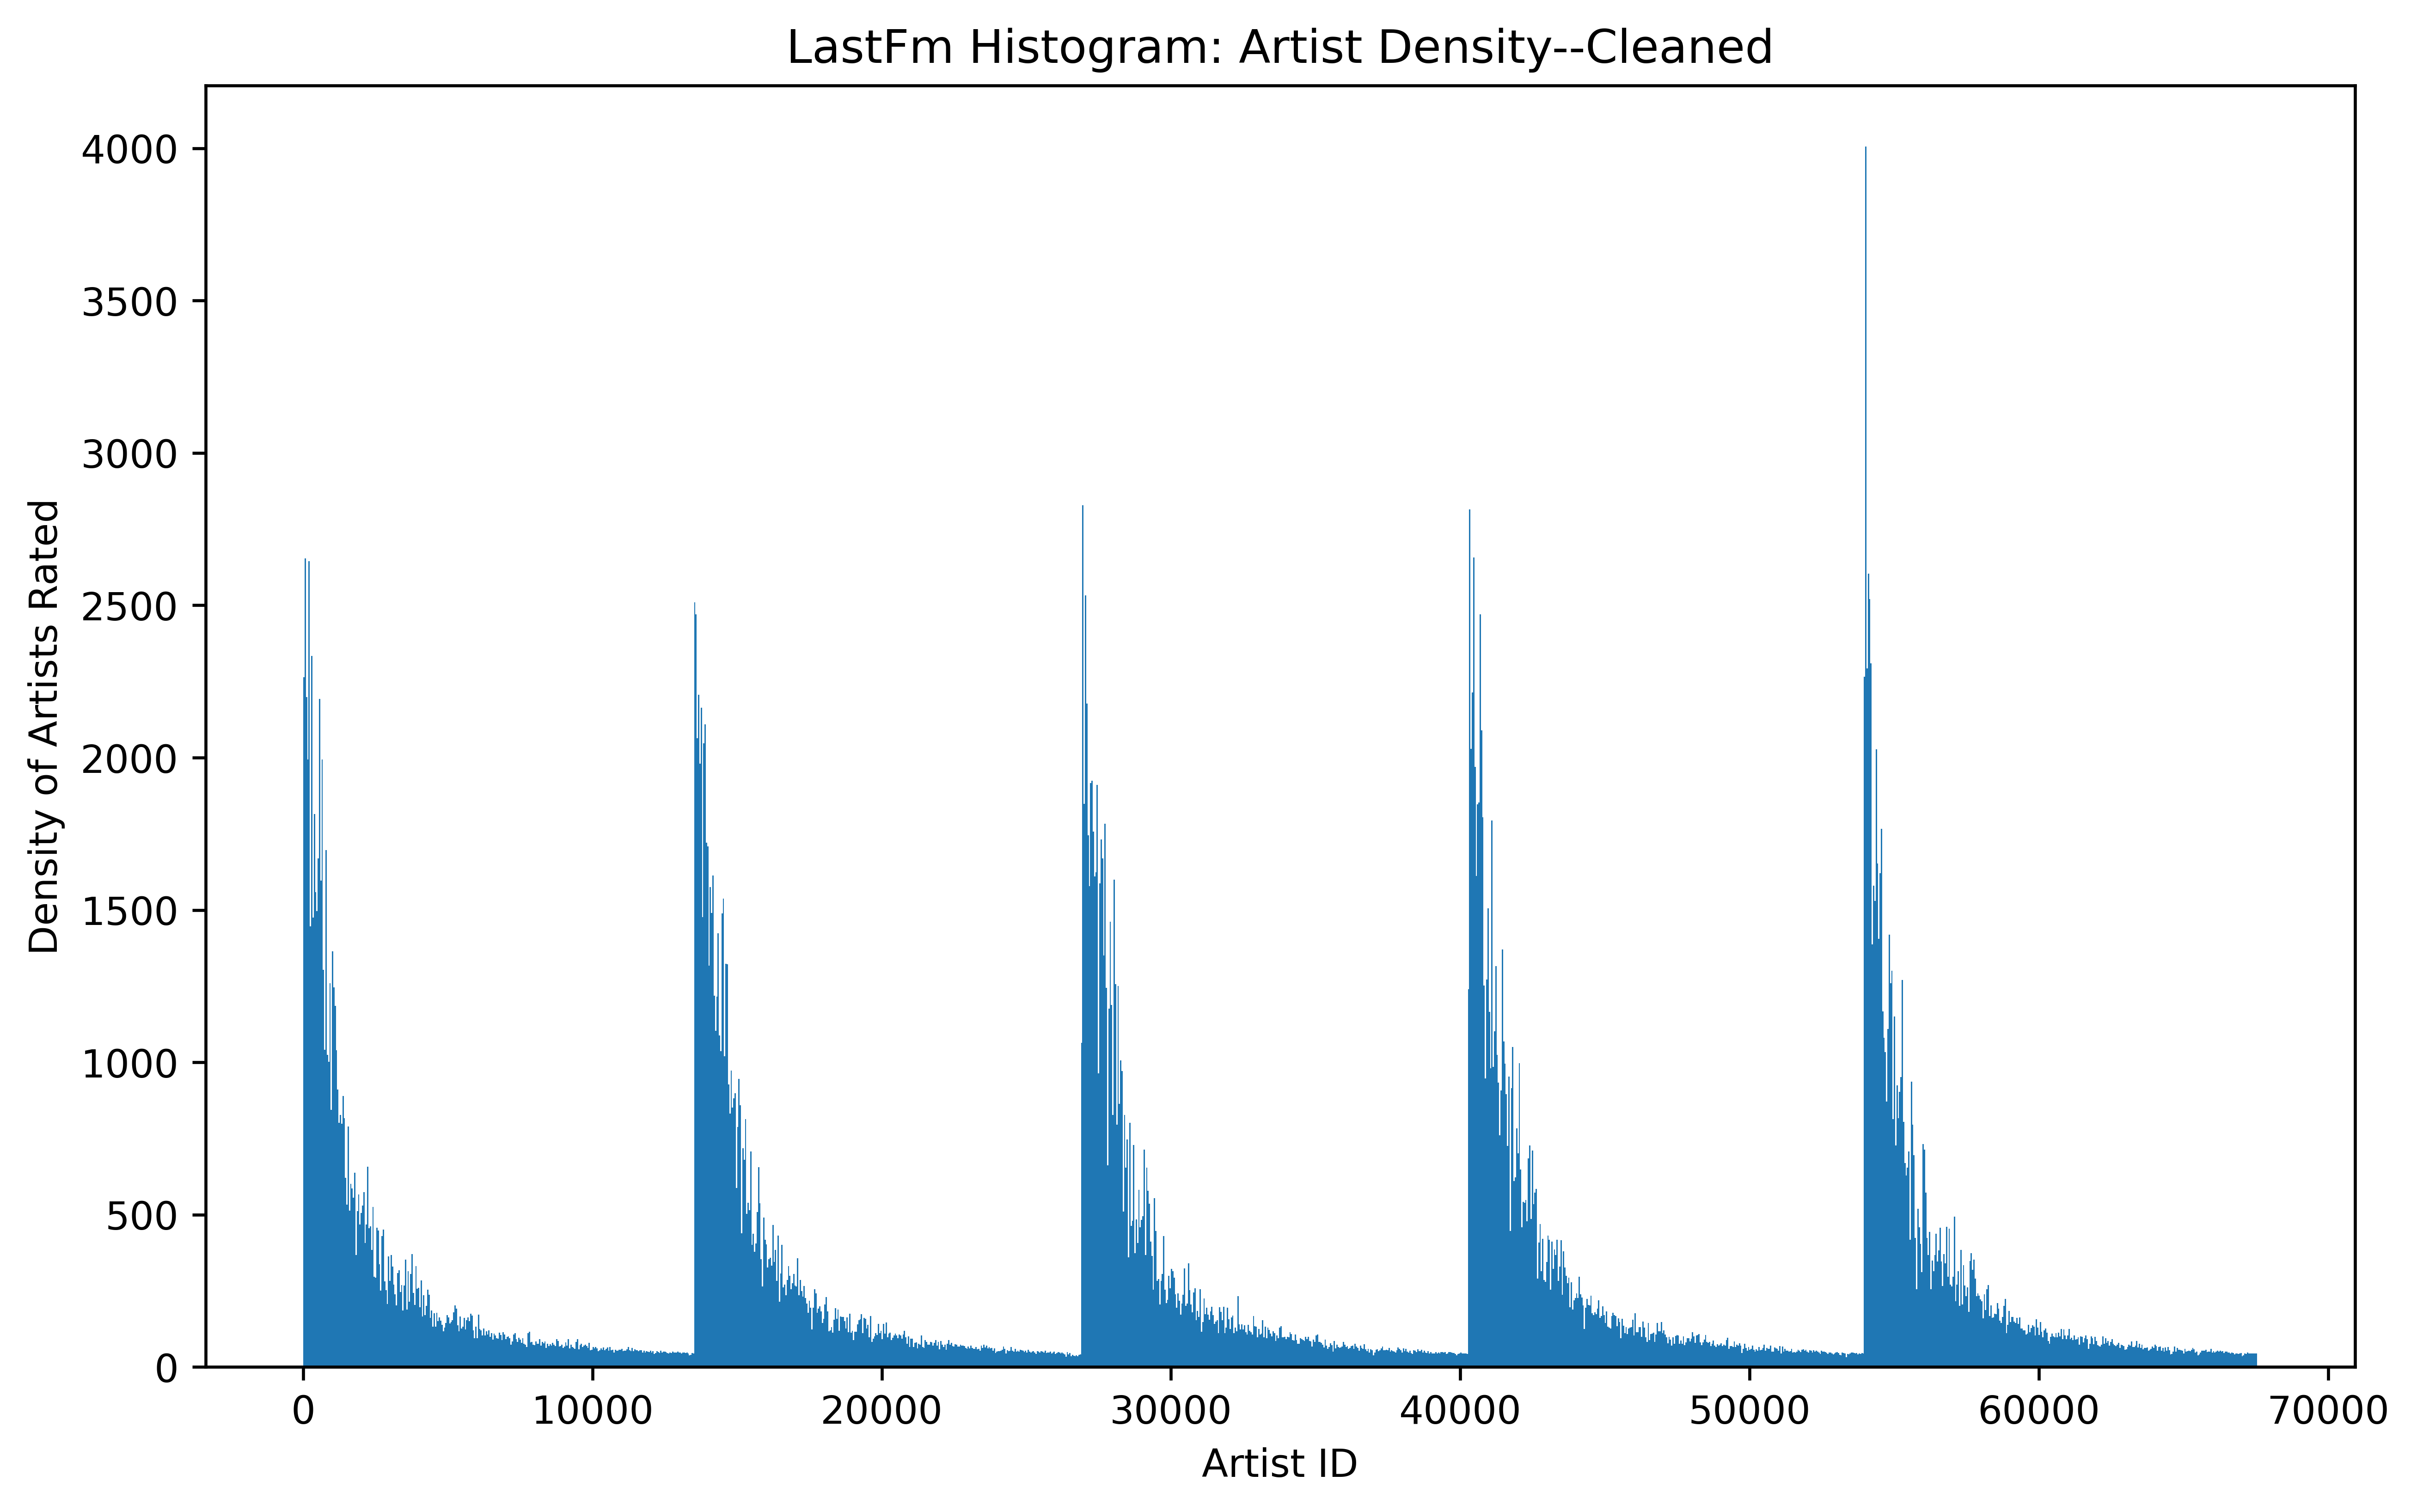

In [113]:
#rated_num3 = filteredRDD.map(lambda x: (int(x[2]))).collect()
%matplotlib inline
x = rated_num3
plt.figure(num=None, figsize=(10, 6), dpi=600)
plt.hist(x,bins=1500,density=False)
plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density--Cleaned')

plt.savefig('visuals/ArtDenseBal.svg')

In [114]:
rdd_out = balancedRDD.map(lambda x: (int(x[0]),int(x[1]),int(x[2]),str(x[3]),int(x[4])))

In [115]:
rdd_out.take(5)

[(564500, 840854315, 27185, ' vanessa hudgens', 216),
 (568200, 842801245, 27264, ' emilie autumn', 91),
 (569400, 845566037, 27317, ' absynthe minded', 87),
 (569500, 846311499, 27328, ' r. kelly', 6),
 (569700, 850268306, 27333, ' westlife', 156)]

In [117]:
rdd = rdd_out.collect()

23/02/24 03:42:28 WARN TaskSetManager: Stage 68 contains a task of very large size (4018 KiB). The maximum recommended task size is 1000 KiB.


In [120]:
with tqdm(total=len(rdd)) as pbar:
    with open("data/balancedRDD.csv", "w") as file:
        
        for r in rdd:
            
            artist = f"{r[3]}".replace(",", " ")

            file.write(f'{r[0]}, {r[1]}, {r[2]}, {artist}, {r[4]}\n')
        
            pbar.update(1)

  0%|          | 0/444042 [00:00<?, ?it/s]

23/02/24 03:45:42 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed (this is expected if the application is shutting down.)
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 35240)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 235, in poll
    if func():
  File "